In [4]:
# Import some libraries from python and set some defaults
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib import rc
import matplotlib.image as mpimg
import sys
import os
import time
sys.path.append(os.getcwd())
# from scipy.interpolate import CubicSpline
import pickle
import copy
from DEq_Solver import DEq_Solver
plt.rcParams.update({'font.size': 17})
params = {'axes.labelsize': 16, 'axes.titlesize': 16}
plt.rcParams.update(params)
rc('animation', html='html5')

In [4]:
from ipywidgets import widgets, interact, interactive, fixed
from ipywidgets import Button, HBox, VBox
import shelve
assessmentName="test_ballistic";
import os

def get_last_value(key):
    if os.path.isfile('.choices.shelve') or os.path.isfile('.choices.shelve.dir'):
        s=shelve.open('.choices.shelve')
        return s.get(key,None)
    return None

def make_value_change_fn(assessmentName,name):
    def fn(change):
        s=shelve.open('.choices.shelve')
        key='{0}_{1}'.format(assessmentName,name)
        s[key]=change['new']
        s.close()
    return fn
 
class myFloatBox:
    def __init__(self,name,description,long_description):
        self.name=name
        self.description=description
        self.long_description=long_description
    def getWidget(self):
        self.widgets=[ 
              widgets.FloatText(
              description=self.description,
        disabled=False,
                  value=get_last_value('{0}_{1}'.format(assessmentName,self.name))
        )]
        
        txt=widgets.HTMLMath(
            value=self.long_description,
            placeholder='',
            description='',
        )
        
        self.widget=VBox([txt]+self.widgets)
        self.widgets[0].observe(make_value_change_fn(assessmentName,self.name), names='value')

        return self.widget
    



# Preamble: workshop notebooks

Work through this notebook cell by cell.

When working on your solution, you can save the notebook as many times as you like. You can also submit 
as many times as you like. In fact, it is a good idea to save and submit often.

**Validate** the notebook before submitting. Use the *validate* button in the browser

**Do not copy or delete one of the original cells**. Doing so means you cannot validate the notebook.
If required, *create a new cell*, and copy the *contents* of another cell.


**Only the last submission before the deadline** will be marked.
Note that you have to **submit** at least once for your work to be marked.


The notebook contains cells with code. Some of the code is (intentionally) missing. Please insert appropriate code below the line 'YOUR CODE HERE'. Cells which do not contain any 'YOUR CODE HERE' lines will allow you to test your code; if they return an error there is something wrong with your implementation; if they do not return an error your code might be correct (it is unfortunately not possible to check for every possible error).

Note:

simply add numerical value in a dropbox for it to get marked

when asked for true/false in a box:

ticking a box means True
not ticking (or ticking an even number of times) yields False


## Workshop IV: Chaos

This workshop looks at chaotic systems and analyses them in terms of Poincare sections.

The Euler-Cromer and the equation for the non-linear pendulum are taken from the previous workshop



We use the same notation as in the Harmonic Motion assignment: the coordinates of a pendulum are the angle measured from the vertical ($\theta$ in the notes), and its time derivative ($\dot\theta\equiv d\theta/dt$). In the implementation below, $\theta$ and $\dot\theta$ are the first and second entry of the state vector $x$:

` x=np.array([theta, d(theta)/dt]) `

The first few cells are identical to the previous notebook, to make sure that the integrator you've developed gives the right answer.


 
  We will use the `Pendulum` class as a kernel for the normal Euler and Runge-Kutta method and the new Euler-Cromer method. We will implement `dx_dt(self,x,t)` for the former and `dx_dt_EC(self,x,t)` for the latter. You have access to


    x        - the state vector
    t        - the time
    self.delta_t  - the time step
    
    self.L        - pendulum's length
    self.g        - gravity acceleration
    self.FD       - driving acceleration
    self.OD       - driving frequency
    self.q        - friction coefficient
    self.nolin    - whether pendulum is linear (small angle approximation)
    
You can copy your answers from the previous workshop    


In [6]:
# physical constants used below, g is average gravitational acceleration on Earth's surface
phys_const = {'g':9.81}  # units [m/s^2]

In [7]:
class Pendulum:
    def __init__(self, L, q=0, F_D=0, Omega_D=0, nonlinear=False):
        """Initialize a pendulum object with 
        length L [m], 
        friction coefficient q [1/s], 
        driving acceleration amplitude F_D [N/kg],
        frequency Omega_D [s^-1]. 
        and a boolean switch to enable the nonlinear pendulum"""
        self.L      = float(L)
        self.q      = float(q)
        self.FD     = float(F_D)
        self.OD     = float(Omega_D)
        self.nonlin = nonlinear
        self.g      = phys_const["g"]             # gravitational acceleration on the Earth's surface [m/s^2]

    def dx_dt(self,x,t):
        # calculate the time derivative for 
        #      - the position, x[0]=theta
        #      - the angular velocity, x[1]=dtheta/dt
        # Note that angles are assumed to be in *radians*
        # Include gravity, friction and driving
        # Implement both linear (small-angle) and non-linear (no small-angle approximation) cases
        # Input:   x     = [theta, dtheta/dt], position and velocity of the pendulum at time t
        #       note: input x should be in the form of a numpy array
        # Returns: dx/dt = [dtheta/dt, d^2theta/dt^2]: speed and acceleration of the pendulum
        #      note: function should return dx/dt as an numpy array
        # YOUR CODE HERE
        dx_dt = np.array([x[0],x[1]])
        
        Omega_squared = (phys_const["g"]/self.L)
        
        if self.nonlin:
            dx_dt[0] = x[1]
            dx_dt[1] = -Omega_squared*np.sin(x[0]) - self.q*x[1] + self.FD*np.sin(self.OD * t)
        else:
            
            dx_dt[0] = x[1]
            dx_dt[1] = -Omega_squared*x[0] - self.q*x[1] + self.FD*np.sin(self.OD * t)
            
        return dx_dt        
       


In [8]:
# this tests the dx_dt implementation
testPend=Pendulum(2.3,1.1,0.5,2.2,False)
testPendNL=Pendulum(2.3,1.1,0.5,2.2,True)
assert np.isclose(testPendNL.dx_dt([0.5,0.3],0.7),[ 0.3, -1.87509123]).all()
assert np.isclose(testPend.dx_dt([0.5,0.3],0.7),[ 0.3, -1.96284578]).all()

In [9]:
class EulerCromerSolver(DEq_Solver):
    def __init__(self,kernel):
        self.kernel  = kernel
    def makeStep(self):
        # this should implement the EC step, as before you have access to
        # time as self.t
        # the time step as self.delta_t
        # the position and velocity as the vector self.x
        # the derivative of x, dx/dt, as the kernel self.kernel.dx_dt
        # output: none
        # makeStep changes the state vector
        #   - update time by the time step
        #   - update x given its time derivative, kernel.dx_dt
        # make sure you update position and velocity in the manner consistent with the Euler-Cromer method
        # YOUR CODE HERE
        
        
        self.x[1] = self.x[1] + self.kernel.dx_dt(self.x,self.t)[1]*self.delta_t
        
        self.x[0] = self.x[0] + self.x[1]*self.delta_t
        self.x = np.array([self.x[0],self.x[1]])
        self.t += self.delta_t
        
        

In [10]:
# this tests the EC step
testEC=EulerCromerSolver(testPend)
testEC.x=[0.3,0.2]
testEC.t=0
testEC.delta_t=0.01
testEC.makeStep()
assert np.isclose(testEC.t,0.01)
assert np.isclose(testEC.x,[ 0.30185004,  0.18500435]).all()

## Evolution of the non-linear driven pendulum

Below we compute the evolution of the non-linear pendulum. Use the following parameters (length `L`, friction coefficient `q`, driving frequency `Omega_D`, initial time `t0`, final time `t1`, all in SI units)

` - L = 9.81, q = 0.5, Omega_D = 2./3.`

` - t0 = 0, t1 = 150`

` - nonlinear = True`

Compute the evolution for two values of the driving acceleration $F_D$, taking $F_D=0.5$ and $F_D=1.2$.

For each of these, calculate the evolution from $\theta_0=0.2$, the launch angle in radians,
as well as for a small difference $\Delta \theta_0=1\times 10^{-3}$ from $\theta_0$.

Overplot the analytical solution as well.
  

Plot $\theta(t)$ for these four cases using the cell below. Use different colours and different linestyles to distinguish the curves. Annotate the axis and provide a legend.

In the right-hand-plot, you will see discontinuities in $\theta(t)$. What are these?
To make the plot look smoother, it makes sense to plot $\sin(\theta)$, rather than $\theta$
Try both options.


Compare your plot to Evolution.pdf. Convince yourself that your solution looks similar.
I used a timestep of dt=0.04

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


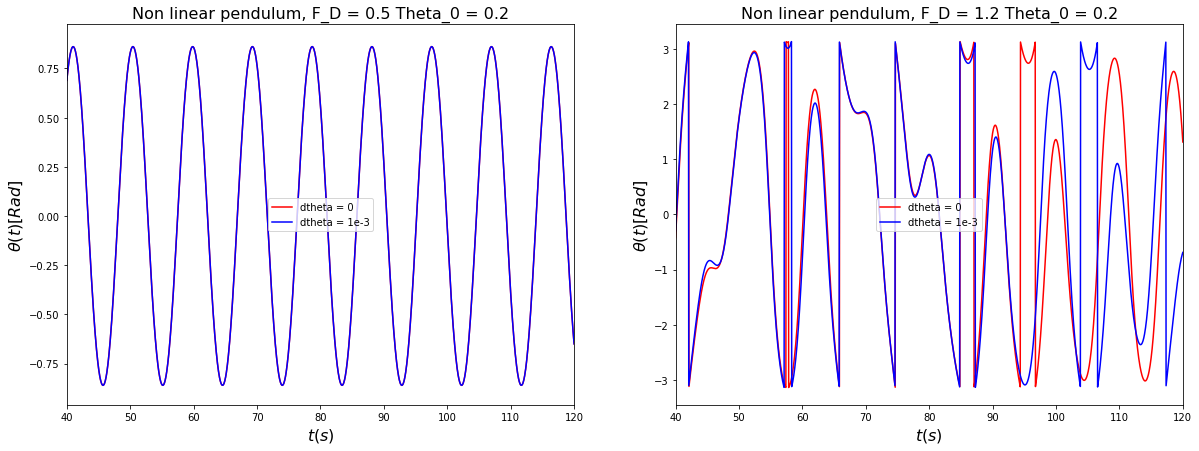

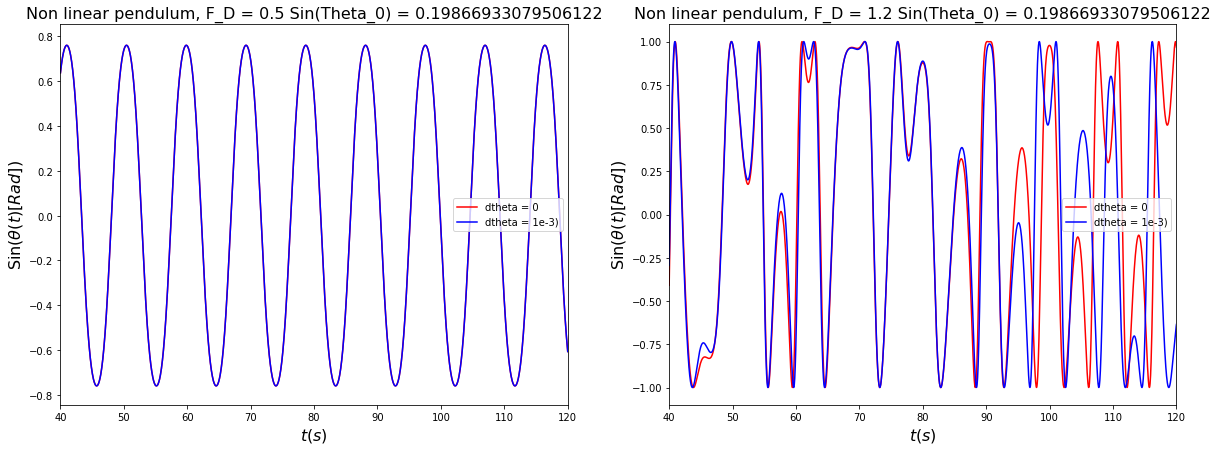

In [11]:
# Make a four panel plot, 2 panels x 2 panels
# Top panels
# Top left: theta(t) for F_D = 0.5, showing the case with launch angle theta0, and launch angle theta_0+dtheta_0
#           use different colours or line-styles to distinguish them. Add a legend
# Top right: same, but for F_D=1.2

# Lower panels: same as top panels, but plotting sin(theta(t))

# Use a pendulum with these parameters
L          = 9.81       
q          = 0.5       # Friction coefficient
Omega_D    = 2./3.     # Driving frequency (1/s)
Period     = 2*np.pi / Omega_D # Driving period (s)
nonlinear  = True      
t0         = 0          # Start time (s)
t1         = 150        # End time (s)
dt         = 0.04       # Time-step (s)
theta0     = 0.2        # launch (initial) angle in radians
dtheta0    = 1e-3       # small difference in launch angle in radians

# Approximate marking scheme
# 2 x 2 panels:                                  2 marks
# top panels contain theta(t):                   2 marks
#    the two cases are explained in the legend:  2 marks
# bottom panels contain sin(theta):              2 marks
# the curves look OK                             2 marks
# YOUR CODE HERE


# store the values of the pendulum as a dictionary
F_d = [0.5,1.2]

method = [(EulerCromerSolver, 'Euler-Cromer')]

solverType = EulerCromerSolver

fig, ax = plt.subplots(1, 2, figsize = (20, 7))
fig, ax1 = plt.subplots(1, 2, figsize = (20, 7))

for i in range(2):
    pendulum_pars = {'g':9.81, 'L':L, 'q':q, 'Omega_D':Omega_D}
    simulation = {'theta_deg':theta0, 't0':t0, 't1': t1, 'dt':dt}
                # create an instance of pendulum from the class, setting the particular values for this run
    pendulum = Pendulum(L=pendulum_pars["L"], q=pendulum_pars["q"], 
                                F_D=F_d[i], Omega_D=pendulum_pars["Omega_D"], 
                                nonlinear=True)

                # this sets the initial conditions: initial dispacement, initial velocity = 0
    x0 = np.array([simulation["theta_deg"] , 0])

            #simulation parameter
    solver           = solverType(pendulum)
    result           = solver.solve(x0, simulation["t0"], simulation["t1"], simulation["dt"])
    ts               = solver.timeSteps()
    theta, dtheta_dt = solver.coordinateSteps() 
    theta         = np.mod(theta, 2.*np.pi)
    mask           = (theta >= np.pi)
    theta[mask]  -= 2*np.pi 

    
    ax[i].plot(ts, theta, color = 'red', label = 'dtheta = 0')
    ax1[i].plot(ts, np.sin(theta), color = 'red', label = 'dtheta = 0 ')
    ax[i].set_title('Non linear pendulum, F_D = '+str(F_d[i])+' Theta_0 = '+str(theta0))
    ax1[i].set_title('Non linear pendulum, F_D = '+str(F_d[i])+' Sin(Theta_0) = '+str(np.sin(theta0)))

    
for i in range(2):
    pendulum_pars = {'g':9.81, 'L':L, 'q':q, 'Omega_D':Omega_D}
    simulation = {'theta_deg':theta0+dtheta0, 't0':t0, 't1': t1, 'dt':dt}
                # create an instance of pendulum from the class, setting the particular values for this run
    pendulum = Pendulum(L=pendulum_pars["L"], q=pendulum_pars["q"], 
                                F_D=F_d[i], Omega_D=pendulum_pars["Omega_D"], 
                                nonlinear=True)

                # this sets the initial conditions: initial dispacement, initial velocity = 0
    x0 = np.array([simulation["theta_deg"] , 0])

            #simulation parameter
    solver           = solverType(pendulum)
    result           = solver.solve(x0, simulation["t0"], simulation["t1"], simulation["dt"])
    ts               = solver.timeSteps()
    theta, dtheta_dt = solver.coordinateSteps() 
    theta         = np.mod(theta, 2.*np.pi)
    mask           = (theta >= np.pi)
    theta[mask]  -= 2*np.pi 

    
    ax[i].plot(ts, theta, color = 'blue', label = 'dtheta = 1e-3')
    ax1[i].plot(ts, np.sin(theta), color = 'blue', label = 'dtheta = 1e-3)')
    ax[i].set_title('Non linear pendulum, F_D = '+str(F_d[i])+' Theta_0 = '+str(theta0))
    ax1[i].set_title('Non linear pendulum, F_D = '+str(F_d[i])+' Sin(Theta_0) = '+str(np.sin(theta0)))
ax[0].legend()
ax[1].legend()
ax1[0].legend()
ax1[1].legend()

ax[0].set_ylabel(r"$\theta(t) [Rad] $")
ax[1].set_ylabel(r"$\theta(t) [Rad] $")
ax1[0].set_ylabel(r"Sin($\theta(t) [Rad] $)")
ax1[1].set_ylabel(r"Sin($\theta(t) [Rad] $)")

ax[0].set_xlabel(r"$t (s) $")
ax[1].set_xlabel(r"$t (s) $")
ax1[0].set_xlabel(r"$t (s) $")
ax1[1].set_xlabel(r"$t (s) $")

ax[0].set_xlim(40,120)
ax[1].set_xlim(40,120)
ax1[0].set_xlim(40,120)
ax1[1].set_xlim(40,120)
    
fig.show()


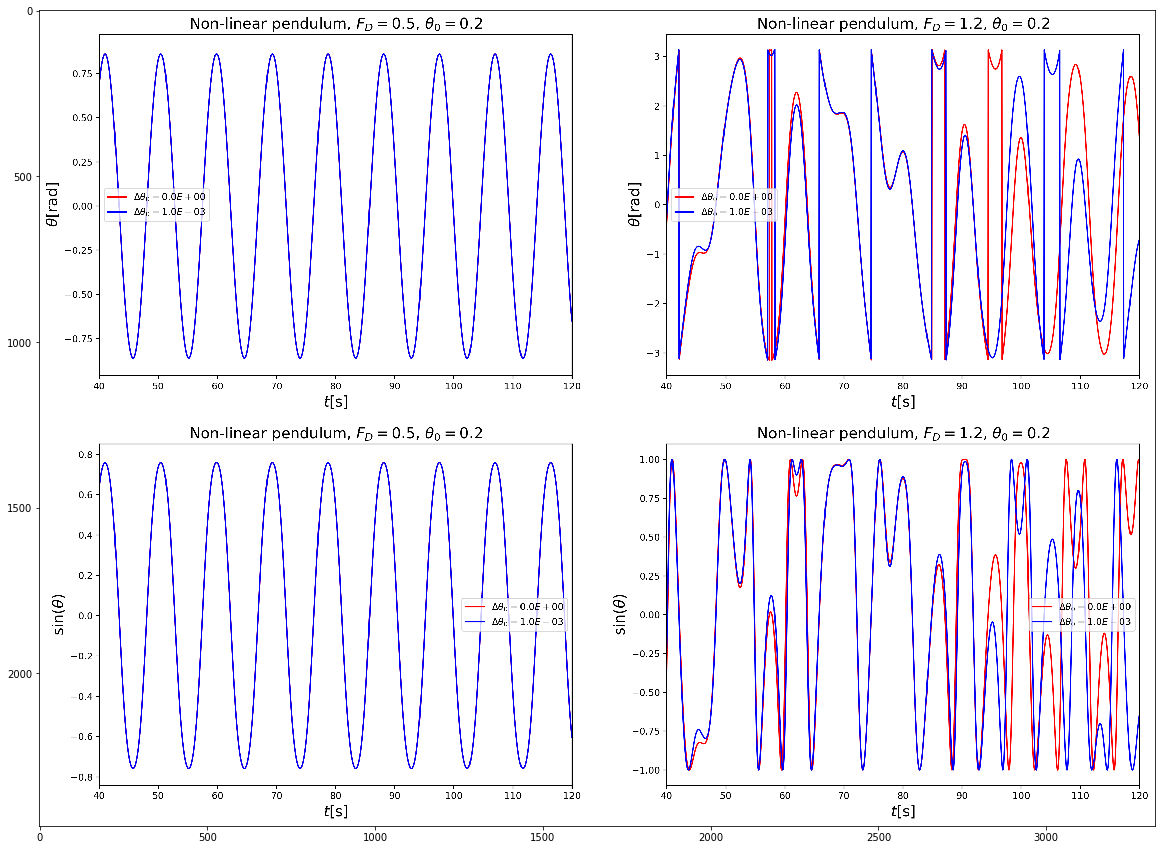

In [12]:
# You may want to compare your results to the plot below
# Note how individual panels have the value of F_D and theta0 in their title 
#   and the use of a legend to distinguish the value of delta theta0

import matplotlib.image as mpimg
img = mpimg.imread('Evolution.png')
fig_size = (20., 15.)
plt.figure(figsize=fig_size)
plt.imshow(img, aspect='auto')
plt.show()

In [13]:
# Write a figure caption. Make sure you describe all the curves.
# Write the caption as code comments - i.e start each line with a "#"



# YOUR CODE HERE

#The position of the non linear pendulum as a function of time ploted for two different driving forced 0.5 and 1.2 respectively.
#The lower quantiles are plots where the approximation sin(theta) = theta has not been made.
#On each plot theta0 = 0.2 and theta0 + dtheta = 0.2 + 1^-3 has been plotted as a function of time in red and blue respectively.\nThe time step is dt = 0.04, q = 0.5 and L = 9.81m.

## Lyapunov exponents

When the pendulum is not chaotic, the evolution of two identical pendulums that start from slightly different launch angles, $\theta_0$, remains close, meaning

$|\Delta \theta(t)|=|\theta_1(t)-\theta_2(t)|$

remains small. This is the case for $F_D=0.5$. In contrast when the pendulum is chaotic, $|\Delta \theta(t)|$ increases rapidly with $t$, until it saturates - meaning $\theta_1$ and $\theta_2$ are uncorrelated.

Plot $\ln|\Delta \theta(t)|$ versus time for the two cases discussed before, $F_D=0.5$ and $F_D=1.2$.
Use the plot labeling in the cell below. 

Note: $\ln$ denotes the natural logarithm, as opposed to $\log\equiv \log_{10}$ which is base 10.

**5 marks**



/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:89: RuntimeWarning: divide by zero encountered in log
/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


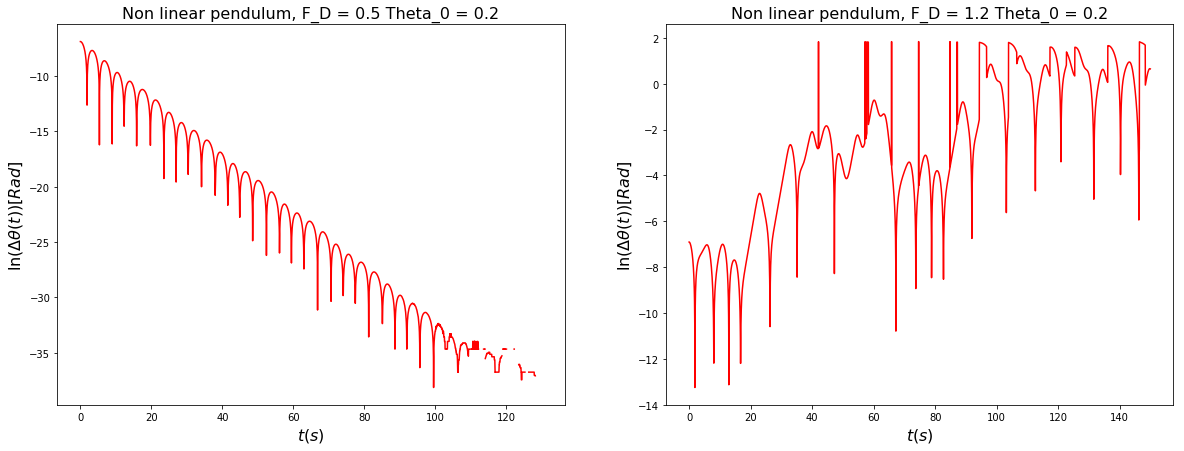

In [14]:
# Plot evolution of ln|Delta theta| between the two pendulums as a function of time, 
# for the two values of F_D in two panels.
# Left panel: case F_D=0.5, right panel: case F_D=1.2


# Approximate marking scheme
# two panels are plotted:     2 marks
# axes are labelled:          2 marks
# value of F_D is indicated   2 marks
# curves looks OK              4 marks
# YOUR CODE HERE

# Make a four panel plot, 2 panels x 2 panels
# Top panels
# Top left: theta(t) for F_D = 0.5, showing the case with launch angle theta0, and launch angle theta_0+dtheta_0
#           use different colours or line-styles to distinguish them. Add a legend
# Top right: same, but for F_D=1.2

# Lower panels: same as top panels, but plotting sin(theta(t))

# Use a pendulum with these parameters
L          = 9.81       
q          = 0.5       # Friction coefficient
Omega_D    = 2./3.     # Driving frequency (1/s)
Period     = 2*np.pi / Omega_D # Driving period (s)
nonlinear  = True      
t0         = 0          # Start time (s)
t1         = 150        # End time (s)
dt         = 0.04       # Time-step (s)
theta0     = 0.2        # launch (initial) angle in radians
dtheta0    = 1e-3       # small difference in launch angle in radians




# store the values of the pendulum as a dictionary
F_d = [0.5,1.2]

method = [(EulerCromerSolver, 'Euler-Cromer')]

solverType = EulerCromerSolver

fig, ax = plt.subplots(1, 2, figsize = (20, 7))


for i in range(2):
    pendulum_pars = {'g':9.81, 'L':L, 'q':q, 'Omega_D':Omega_D}
    simulation = {'theta_deg':theta0, 't0':t0, 't1': t1, 'dt':dt}
                # create an instance of pendulum from the class, setting the particular values for this run
    pendulum = Pendulum(L=pendulum_pars["L"], q=pendulum_pars["q"], 
                                F_D=F_d[i], Omega_D=pendulum_pars["Omega_D"], 
                                nonlinear=True)

                # this sets the initial conditions: initial dispacement, initial velocity = 0
    x0 = np.array([simulation["theta_deg"] , 0])

            #simulation parameter
    solver           = solverType(pendulum)
    result           = solver.solve(x0, simulation["t0"], simulation["t1"], simulation["dt"])
    ts               = solver.timeSteps()
    theta1, dtheta_dt1 = solver.coordinateSteps() 
    theta1         = np.mod(theta1, 2.*np.pi)
    mask           = (theta1 >= np.pi)
    theta1[mask]  -= 2*np.pi 

    
    

    pendulum_pars = {'g':9.81, 'L':L, 'q':q, 'Omega_D':Omega_D}
    simulation = {'theta_deg':theta0+dtheta0, 't0':t0, 't1': t1, 'dt':dt}
                # create an instance of pendulum from the class, setting the particular values for this run
    pendulum = Pendulum(L=pendulum_pars["L"], q=pendulum_pars["q"], 
                                F_D=F_d[i], Omega_D=pendulum_pars["Omega_D"], 
                                nonlinear=True)

                # this sets the initial conditions: initial dispacement, initial velocity = 0
    x0 = np.array([simulation["theta_deg"] , 0])

            #simulation parameter
    solver           = solverType(pendulum)
    result           = solver.solve(x0, simulation["t0"], simulation["t1"], simulation["dt"])
    ts               = solver.timeSteps()
    theta2, dtheta_dt = solver.coordinateSteps() 
    theta2         = np.mod(theta2, 2.*np.pi)
    mask           = (theta2 >= np.pi)
    theta2[mask]  -= 2*np.pi 

    
    ax[i].plot(ts, np.log(abs(theta1-theta2)), color = 'red')
    
    ax[i].set_title('Non linear pendulum, F_D = '+str(F_d[i])+' Theta_0 = '+str(theta0))
 

ax[0].set_ylabel(r"ln(Δ$\theta(t))   [Rad] $")
ax[1].set_ylabel(r"ln(Δ$\theta(t))   [Rad] $")


ax[0].set_xlabel(r"$t (s) $")
ax[1].set_xlabel(r"$t (s) $")


#ax[0].set_xlim(0,140)
#ax[1].set_xlim(0,140)




    
fig.show()


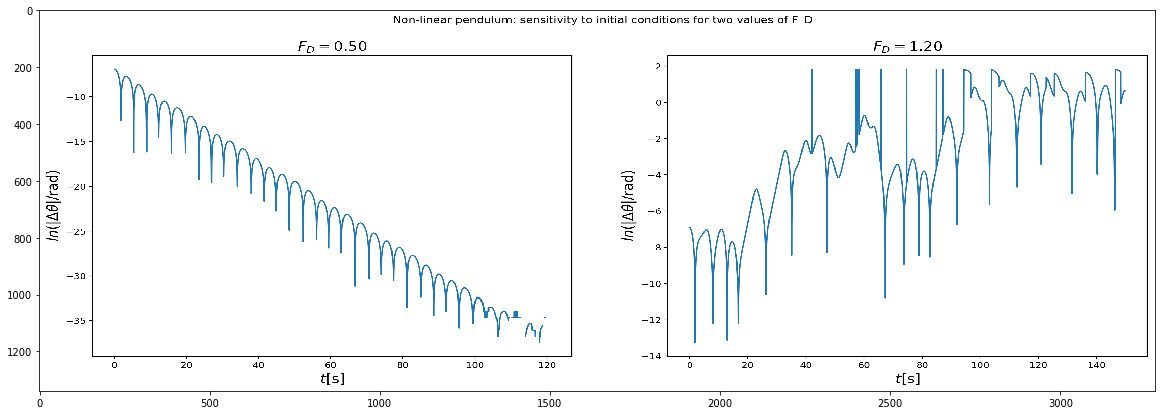

In [15]:
# You may want to compare your results to the plot below
# Note how individual panels have the value of F_D and theta0 in their title 
#   and the use of a legend to distinguish the value of delta theta0

import matplotlib.image as mpimg
img = mpimg.imread('Chaos1.png')
fig_size = (20., 7.)
plt.figure(figsize=fig_size)
plt.imshow(img, aspect='auto')
plt.show()

In [16]:
# Write a figure caption for these figures
# Write the caption as code comments - i.e start each line with a "#"
# YOUR CODE HERE

# The natural log of the absolute difference between theta 1 and theta 1 + 10**-3 has been plotted agains time for two different driving forces, 0.5 and 1.2 respectively. 

"""
I did not talk about the plot i.e talk about the differnece going to -inf as for my undergraduate we were told thta is more for the report.
"""

'\nI did not talk about the plot i.e talk about the differnece going to -inf as for my undergraduate we were told thta is more for the report.\n'

### Computing the Lyapunov exponents

To compute the Lyapunov exponents, we need to fit a set of points with a straight line. Examine the cell below how this could be done using the numpy function `polyfit`.


result of the fit: intercept =  0.07539097801429172  slope =  3.5302122297874123


/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


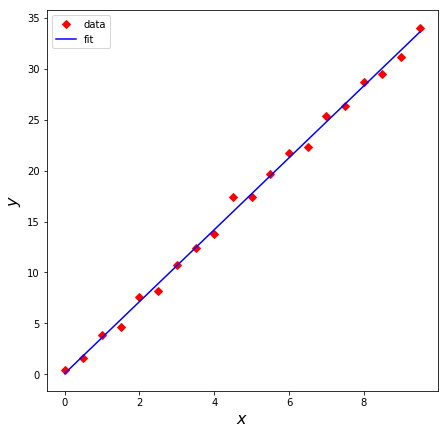

In [17]:
# Example of fitting data with a straight line using polyfit
#
x = np.arange(0, 10, 0.5)
y = 0.2 + 3.5 * x                                     # linear relation to be recovered

# add some small scatter
np.random.seed(12)                                    # set random seed
y += np.random.normal(0, 0.5, len(y))                 # Gaussian distributed scatter

# fit with polynomial
c1, c0     = np.polyfit(x, y, 1)
print("result of the fit: intercept = ", c0, " slope = ", c1)
fit = c0 + c1 * x


fig, ax = plt.subplots(1, 1, figsize = (7, 7))
ax.plot(x, y, 'D', color='red', label='data')
ax.plot(x, fit, '-', color='blue', label='fit')
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
ax.legend()
fig.show()






/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:86: RuntimeWarning: divide by zero encountered in log
/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


result of the fit: intercept =  -7.5771667057219  slope =  -0.25259946479520357
result of the fit: intercept =  -7.111025849626573  slope =  0.060234717265206746


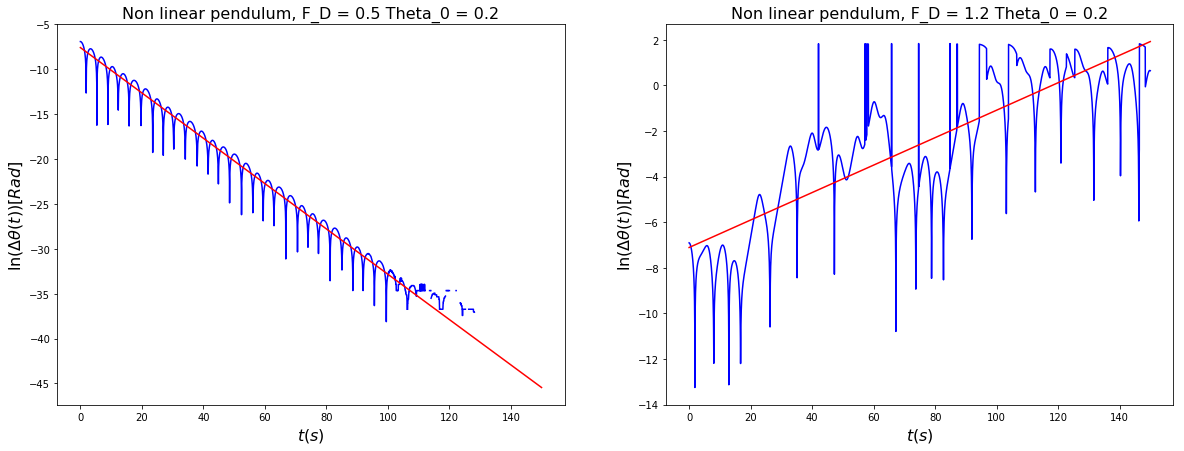

In [18]:
# Fit a straight line to local maxima to estimate the value of Lyapunov exponents in both cases

# Plot the evolution of ln(|Delta theta|) as a function of time
#   label the plot (for both cases) and label the axes
#   you may want to re-use the code you alredy wrote for this
#  Next:
#  plot the points to which you are fitting a straight line to infer the Lyapunov exponent
#  overplot the fit
#  Use a legend

# Approximate marking scheme
# panels from before are reproduced (including labels):    2 marks
# maxima are correctly computed and indicated:             4 marks
# fit is overplotted:                                      2 marks
# fit looks OK                                             2 marks

# Then answer the questions below
# YOUR CODE HERE

# Use a pendulum with these parameters
L          = 9.81       
q          = 0.5       # Friction coefficient
Omega_D    = 2./3.     # Driving frequency (1/s)
Period     = 2*np.pi / Omega_D # Driving period (s)
nonlinear  = True      
t0         = 0          # Start time (s)
t1         = 150        # End time (s)
dt         = 0.04       # Time-step (s)
theta0     = 0.2        # launch (initial) angle in radians
dtheta0    = 1e-3       # small difference in launch angle in radians




# store the values of the pendulum as a dictionary
F_d = [0.5,1.2]

method = [(EulerCromerSolver, 'Euler-Cromer')]

solverType = EulerCromerSolver

fig, ax = plt.subplots(1, 2, figsize = (20, 7))


for i in range(2):
    pendulum_pars = {'g':9.81, 'L':L, 'q':q, 'Omega_D':Omega_D}
    simulation = {'theta_deg':theta0, 't0':t0, 't1': t1, 'dt':dt}
                # create an instance of pendulum from the class, setting the particular values for this run
    pendulum = Pendulum(L=pendulum_pars["L"], q=pendulum_pars["q"], 
                                F_D=F_d[i], Omega_D=pendulum_pars["Omega_D"], 
                                nonlinear=True)

                # this sets the initial conditions: initial dispacement, initial velocity = 0
    x0 = np.array([simulation["theta_deg"] , 0])

            #simulation parameter
    solver           = solverType(pendulum)
    result           = solver.solve(x0, simulation["t0"], simulation["t1"], simulation["dt"])
    ts               = solver.timeSteps()
    theta1, dtheta_dt1 = solver.coordinateSteps() 
    theta1         = np.mod(theta1, 2.*np.pi)
    mask           = (theta1 >= np.pi)
    theta1[mask]  -= 2*np.pi 

    
    

    pendulum_pars = {'g':9.81, 'L':L, 'q':q, 'Omega_D':Omega_D}
    simulation = {'theta_deg':theta0+dtheta0, 't0':t0, 't1': t1, 'dt':dt}
                # create an instance of pendulum from the class, setting the particular values for this run
    pendulum = Pendulum(L=pendulum_pars["L"], q=pendulum_pars["q"], 
                                F_D=F_d[i], Omega_D=pendulum_pars["Omega_D"], 
                                nonlinear=True)

                # this sets the initial conditions: initial dispacement, initial velocity = 0
    x0 = np.array([simulation["theta_deg"] , 0])

            #simulation parameter
    solver           = solverType(pendulum)
    result           = solver.solve(x0, simulation["t0"], simulation["t1"], simulation["dt"])
    #ts               = solver.timeSteps()
    theta2, dtheta_dt = solver.coordinateSteps() 
    theta2         = np.mod(theta2, 2.*np.pi)
    mask           = (theta2 >= np.pi)
    theta2[mask]  -= 2*np.pi 
    delta_theta = np.log(abs(theta1-theta2))

    
    ax[i].plot(ts, delta_theta, color = 'blue')
    
    ax[i].set_title('Non linear pendulum, F_D = '+str(F_d[i])+' Theta_0 = '+str(theta0))
    
    
    if i ==0 :
        
        c1, c0     = np.polyfit(ts[:2500], delta_theta[:2500] , 1)
        
    else:
        c1, c0     = np.polyfit(ts, delta_theta , 1)
    print("result of the fit: intercept = ", c0, " slope = ", c1)
    fit = c0 + c1 * ts
    ax[i].plot(ts, fit, color = 'Red')
    
    """
    # fit with polynomial
    c1, c0     = np.polyfit(ts, delta_theta , 1)
    print("result of the fit: intercept = ", c0, " slope = ", c1)
    fit = c0 + c1 * ts
    ax[i].plot(ts, fit, color = 'Red')
    """


 

ax[0].set_ylabel(r"ln(Δ$\theta(t))   [Rad] $")
ax[1].set_ylabel(r"ln(Δ$\theta(t))   [Rad] $")


ax[0].set_xlabel(r"$t (s) $")
ax[1].set_xlabel(r"$t (s) $")


#ax[0].set_xlim(0,120)
#ax[1].set_xlim(0,120)




    
fig.show()


In [5]:
chaos0=myFloatBox('chaos0',r"$\lambda=$","Estimate the Lyapunov exponent $\lambda$ for the non-chaotic case."
               " Your value should be accurate to within a factor 2")
chaos0.getWidget()

In [6]:
chaos1=myFloatBox('chaos1',r"$\lambda=$","Estimate the Lyapunov exponent $\lambda$ for the chaotic case."
               " Your value should be accurate to within a factor 2")
chaos1.getWidget()

## Phase-space diagram

Next we examine the phase-space diagram of a non-linear pendulum

For the same parameters of the non-linear pendulum as used before, we will make a phase-space diagram. Do so for the two values of the driving amplitude as before that we used earlier


/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


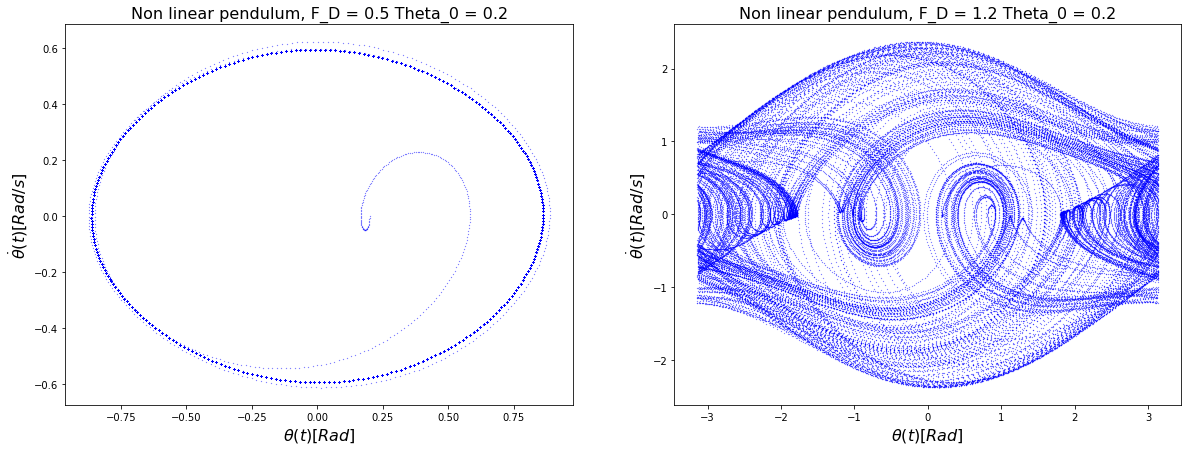

In [21]:
# For the same parameters of the non-linear pendulum, make a phase-space diagram
#    for the same two values of the driving amplitude as before

F_Ds        = [0.5,1.2]     # For these two values of driving amplitude

# The next lines uses the Period of the driving force (called Period)
# We specify the end of the calculation in units of the Period, computed already in one of the previous cells
t1          = 200 * Period         # end time of the calculation
NperPeriod  = 300           
dt          = Period / NperPeriod  # Set time-step as a fraction of the period

# make two plots:
#  left panel:  phase-space diagram for F_D = 0.5, 
#  right panel: phase-space diagram for F_D = 1.2
#    (the two values of the driving amplitude that we have been using so far)
#  make sure to add axis labels, and annotate the plots with the value of F_D

# You may want to store the evolution for each case, since we will make more plots from the computed
#    evolution

# YOUR CODE HERE

# Use a pendulum with these parameters
L          = 9.81       
q          = 0.5       # Friction coefficient
Omega_D    = 2./3.     # Driving frequency (1/s)
Period     = 2*np.pi / Omega_D # Driving period (s)
nonlinear  = True      
t0         = 0          # Start time (s)
       # End time (s)
        # Time-step (s)
theta0     = 0.2        # launch (initial) angle in radians
dtheta0    = 1e-3       # small difference in launch angle in radians




# store the values of the pendulum as a dictionary
F_d = [0.5,1.2]

method = [(EulerCromerSolver, 'Euler-Cromer')]

solverType = EulerCromerSolver

fig, ax = plt.subplots(1, 2, figsize = (20, 7))
from scipy.interpolate import UnivariateSpline
Results = {}
for i in range(2):
    pendulum_pars = {'g':9.81, 'L':L, 'q':q, 'Omega_D':Omega_D}
    simulation = {'theta_deg':theta0, 't0':t0, 't1': t1, 'dt':dt}
                # create an instance of pendulum from the class, setting the particular values for this run
    pendulum = Pendulum(L=pendulum_pars["L"], q=pendulum_pars["q"], 
                                F_D=F_d[i], Omega_D=pendulum_pars["Omega_D"], 
                                nonlinear=True)

                # this sets the initial conditions: initial dispacement, initial velocity = 0
    x0 = np.array([simulation["theta_deg"] , 0])

            #simulation parameter
    solver           = solverType(pendulum)
    result           = solver.solve(x0, simulation["t0"], simulation["t1"], simulation["dt"])
    ts               = solver.timeSteps()
    theta, dtheta_dt = solver.coordinateSteps() 
    theta         = np.mod(theta, 2.*np.pi)
    mask           = (theta >= np.pi)
    theta[mask]  -= 2*np.pi 
    
    Results[i] = {}
    Results[i]['t']          = ts
    Results[i]['theta']      = theta
    Results[i]['dtheta_dt']  = dtheta_dt
   

    
    
    ax[i].plot(theta,dtheta_dt , color = 'blue', marker = '.', markersize = 0.4, linestyle = '')
    
    ax[i].set_title('Non linear pendulum, F_D = '+str(F_d[i])+' Theta_0 = '+str(theta0))   

    


 
ax[0].set_ylabel(r"$\dot\theta(t) [Rad/s] $")

ax[1].set_ylabel(r"$\dot\theta(t) [Rad/s] $")

ax[0].set_xlabel(r"$\theta(t) [Rad] $")
ax[1].set_xlabel(r"$\theta(t) [Rad] $")





    
fig.show()


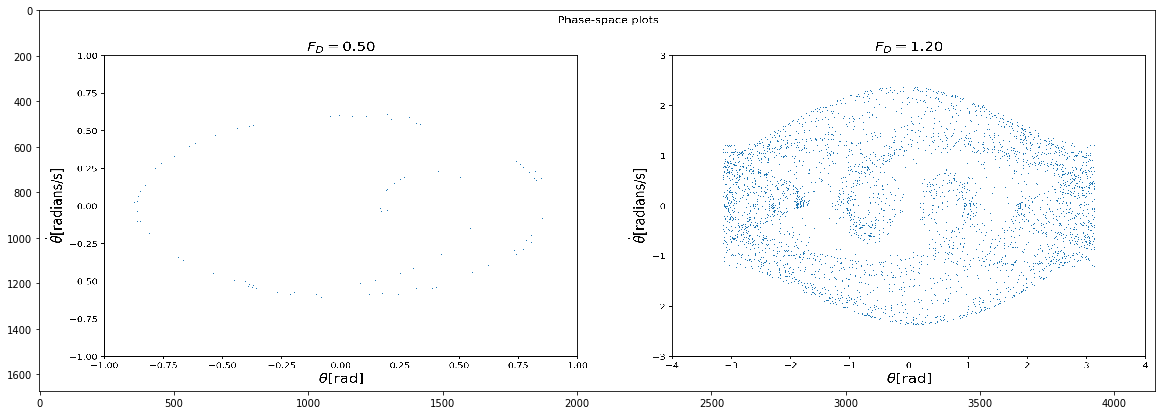

In [22]:
# You may want to compare your results to the plot below
# Note how individual panels have the value of F_D and theta0 in their title 
#   and the use of a legend to distinguish the value of delta theta0
# Note that you can also display the figure in its own browser window by going to the 
#   Chaos directory and opening the file Chaos2.png. The phase space diagram 
#   can appear faint when plotted in the notebook (especially the left panel) and 
#   it may be easier to compare to the file Chaos2.png opened in a browser window.


import matplotlib.image as mpimg
img = mpimg.imread('Chaos2.png')
fig_size = (20., 7.)
plt.figure(figsize=fig_size)
plt.imshow(img, aspect='auto')
plt.show()

Extract from the phase-diagram those points for which $\Omega_D t$ is $2N\pi$, where $N$ is an integer.
Use this subset to make a Poincare section.
Use the plot labelling in the cell below.

**5 marks**

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


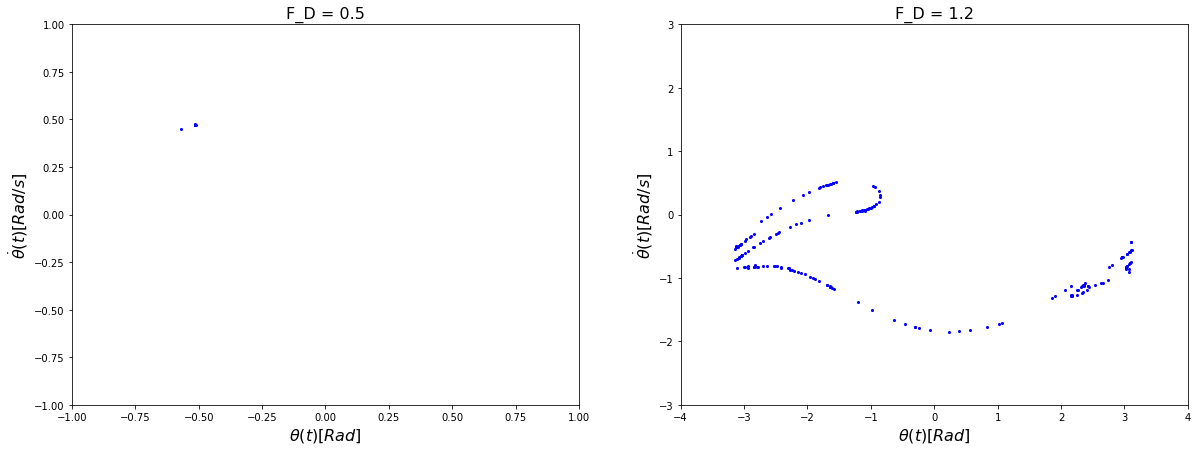

In [23]:
# Extract Poincar\'e section, byt making a phase-space diagram but selecting those points
# for which Omega_D t = N 2pi, where N is an integer


# fig, ax = plt.subplots(1, 1, figsize = (7, 7))

# panel     = 0
# F_D       = F_Ds[panel]
# t         = soln[F_D]["t"]
# theta     = soln[F_D]["theta"]
# dtheta_dt = soln[F_D]["dtheta_dt"]
# ax.plot(t, np.sin(Omega_D * t))
# ts        = t[NperPeriod::NperPeriod]
# print(ts[0:5])
# ax.plot(ts, np.sin(Omega_D * ts), 'D', color='red')

# phi        = np.mod(Omega_D*t, 2*np.pi)
# mask       = phi > np.pi
# phi[mask] -= 2*np.pi
# mask       = np.abs(phi) < 1e-3
# ts         = t[mask]
# print(ts[0:5])
# ax.plot(ts, np.sin(Omega_D * ts)+0.1, 'D', color='blue')


# ax.set_xlim([0,100])
# fig.show()
    

fig, ax1 = plt.subplots(1, 2, figsize = (20, 7))


for i in range(2):
    

    F_D       = F_Ds[i]
    t         = Results[i]['t']
    theta     = Results[i]['theta']
    dtheta_dt = Results[i]['dtheta_dt']



    theta = theta[NperPeriod::NperPeriod] #Basically [start:end:step]
    dtheta_dt = dtheta_dt[NperPeriod::NperPeriod]

    ax1[i].plot(theta, dtheta_dt, 'D', color='red', marker = '.', markersize = 2, linestyle = '')
    ax1[i].plot(theta, dtheta_dt, 'D', color='blue', marker = '.', markersize = 4, linestyle = '')
    ax1[i].set_title('F_D = '+str(F_d[i]))





ax1[1].set_xlim([-4,4])
ax1[1].set_ylim([-3,3])

ax1[0].set_xlim([-1,1])
ax1[0].set_ylim([-1,1])

ax1[0].set_ylabel(r"$\dot\theta(t) [Rad/s] $")

ax1[1].set_ylabel(r"$\dot\theta(t) [Rad/s] $")

ax1[0].set_xlabel(r"$\theta(t) [Rad] $")
ax1[1].set_xlabel(r"$\theta(t) [Rad] $")




fig.show()

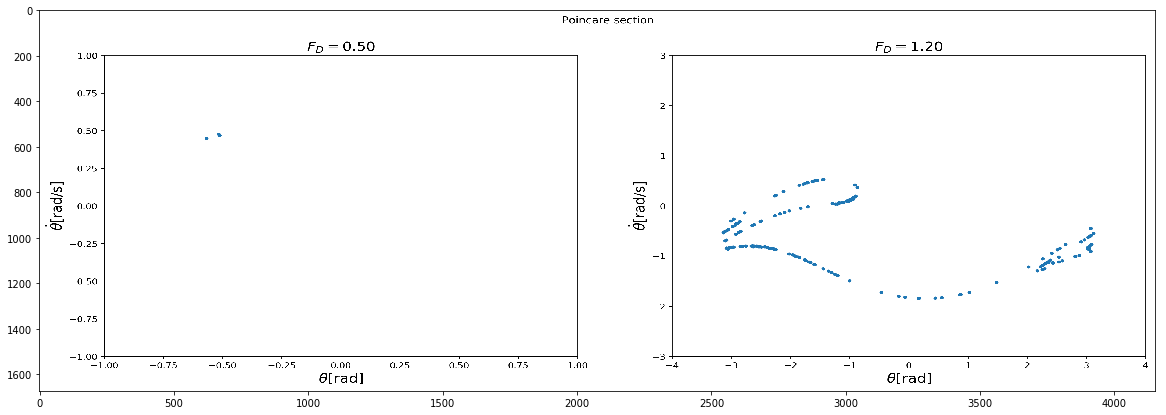

In [24]:
# You may want to compare your results to the plot below
# Note how individual panels have the value of F_D and theta0 in their title 
#   and the use of a legend to distinguish the value of delta theta0
# Note that you can also display the figure in its own browser window by going to the Chaos directory.

import matplotlib.image as mpimg
img = mpimg.imread('Chaos3.png')
fig_size = (20., 7.)
plt.figure(figsize=fig_size)
plt.imshow(img, aspect='auto')
plt.show()

## Compute the bifurcation diagram for the non-linear pendulum

**5 marks**


We will compute the evolution of the non-linear pendulum for a range of amplitudes, F_D, of the driving force. We pick values of F_D such that they sample more finely the region where period doubling occurs.

In [25]:
# Use this cell to perform the calculation and store the result
# Make sure you pick only the values of (theta, dtheta_dt) that your are going to plot to save memory
# We will use the next cell to plot the results

# Calculate evolution for the following values of the amplitude of the driving force
FD1        = np.arange(1.35, 1.47 , 0.005)
FD2        = np.arange(1.471, 1.488 , 0.001)   # more finely sampled in the interesting region
F_Ds       = np.concatenate([FD1, FD2])

# Run the pendulum for each value in F_Ds, from t0 = 0, to t1 = 400 Periods
# Use a timestep equal to the period of the driving force divided by 300
# Plot the bifurcation diagram for from t = 300 Periods, to t=400 Periods
# This calculation may take a minute or two to run.
Period     = 2*np.pi / Omega_D
NperPeriod = 300                  # Number of steps per period
dt         = Period / NperPeriod  # time step
t1         = 400*Period           # final time
Prec       = 300                  # store results from Pred periods on

# we time the computation
start_time = time.time()

# We store the results in a dictionary
soln       = {}

# YOUR CODE HERE


# Use a pendulum with these parameters
L          = 9.81       
q          = 0.5       # Friction coefficient
Omega_D    = 2./3.     # Driving frequency (1/s)
nonlinear  = True      
t0         = 0          # Start time (s)
theta0     = 0.2        # launch (initial) angle in radians


method = [(EulerCromerSolver, 'Euler-Cromer')]
solverType = EulerCromerSolver

from scipy.interpolate import UnivariateSpline

for i in range(len(F_Ds)):
    
    pendulum_pars = {'g':9.81, 'L':L, 'q':q, 'Omega_D':Omega_D}
    simulation = {'theta_deg':theta0, 't0':t0, 't1': t1, 'dt':dt}
                # create an instance of pendulum from the class, setting the particular values for this run
    pendulum = Pendulum(L=pendulum_pars["L"], q=pendulum_pars["q"], 
                                F_D=F_Ds[i], Omega_D=pendulum_pars["Omega_D"], 
                                nonlinear=True)

                # this sets the initial conditions: initial dispacement, initial velocity = 0
    x0 = np.array([simulation["theta_deg"] , 0])
    
            #simulation parameter
    solver           = solverType(pendulum)
    result           = solver.solve(x0, simulation["t0"], simulation["t1"], simulation["dt"])
    ts               = solver.timeSteps()
    theta, dtheta_dt = solver.coordinateSteps() 
    theta         = np.mod(theta, 2.*np.pi)
    mask           = (theta >= np.pi)
    theta[mask]  -= 2*np.pi 
    

    soln[i] = {}
    soln[i]['t']      = ts
    soln[i]['theta']      = theta
    soln[i]['dtheta_dt']  = dtheta_dt
   

cpu_time = time.time() - start_time
print(" Calculation finished, cpu time used = ", cpu_time)       


 Calculation finished, cpu time used =  61.974387645721436


Plot your results using the cell below

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


"\nFinds the first time index where t = 300 * Period\nand finds the second time index where t = (300 * period) + Period\n\n\n\nfor i in range(len(t)):\n    if isclose(t[i],(2827.4333882308138+Period), abs_tol = 10**-5): \n    \n\n        print('hhh',t[i])\n        print('this',i)\n    \n"

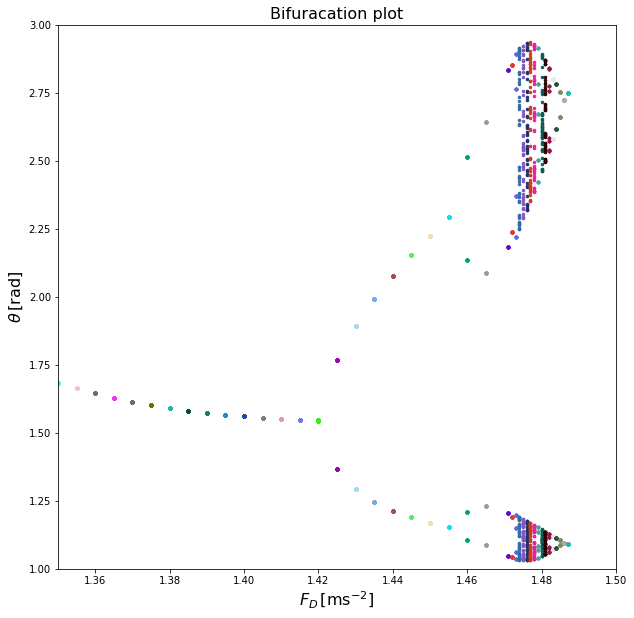

In [26]:
# Bifurcation plot
fig, ax = plt.subplots(1, 1, figsize = (10, 10))
ax.set_title('Bifuracation plot')
ax.set_xlabel(r'$F_D\,[\mathrm{m s^{-2}}]$')
ax.set_ylabel(r'$\theta\,[\mathrm{rad}]$')
ax.set_xlim(1.35, 1.5)
ax.set_ylim(1, 3)

for i in range(len(F_Ds)):
    

    F_D       = F_Ds[i]
    t = soln[i]['t']
    theta     = soln[i]['theta']
    dtheta_dt = soln[i]['dtheta_dt']

    theta = theta[90000::NperPeriod]
 
    F_list = []
    for i in range(len(theta)):
        F_list.append(F_D)
        

    ax.plot(F_list,theta, 'D', color=np.random.rand(3,), marker = '.', markersize = 5, linestyle = '')

fig.show()

"""
Finds the first time index where t = 300 * Period
and finds the second time index where t = (300 * period) + Period



for i in range(len(t)):
    if isclose(t[i],(2827.4333882308138+Period), abs_tol = 10**-5): 
    

        print('hhh',t[i])
        print('this',i)
    
"""



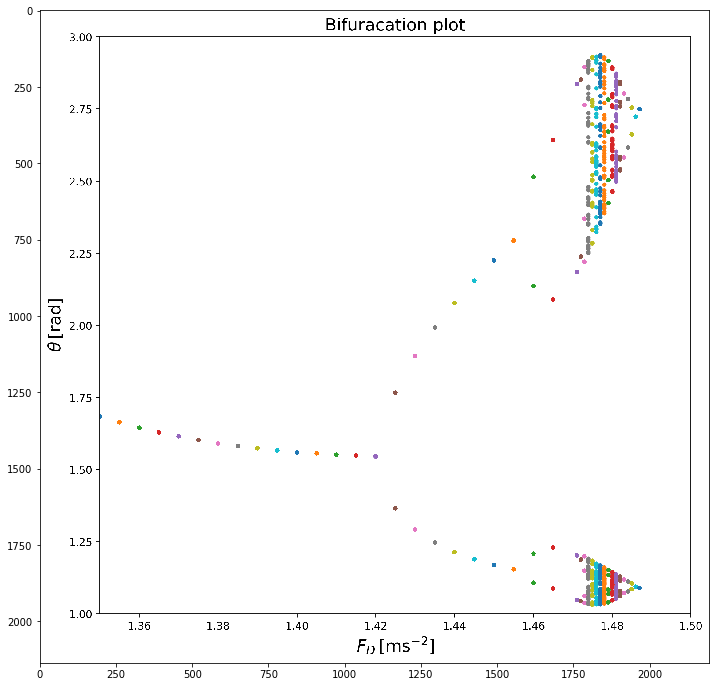

In [27]:
# You may want to compare your results to the plot below
# Note how individual panels have the value of F_D and theta0 in their title 
#   and the use of a legend to distinguish the value of delta theta0
# Note that you can also display the figure in its own browser window by going to the Chaos directory.

import matplotlib.image as mpimg
img = mpimg.imread('Chaos4.png')
fig_size = (12., 12.)
plt.figure(figsize=fig_size)
plt.imshow(img, aspect='auto')
plt.show()

## Playground

Investigate how the bifurcation diagram looks like if you

 - plot $\theta(t)$ when $\Omega_D t = \pi + n 2\pi$
 
 - plot $\dot\theta$ on the $y$-axis rather than $\theta$